In [1]:
import numpy as np
import xarray as xr
import dask
import zarr

### Load dataset

In [2]:
# Anomaly budget
ds_budgH = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH/')

In [3]:
# Main disagnostic output
ds_main = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_output/')
coords_main = ds_main.coords.to_dataset().reset_coords()
ds_main = ds_main.reset_coords(drop=True)

### Depth average (upper Z)

In [4]:
ds_budgH.coords['Z'] = coords_main.Z
ds_budgH.coords['hFacC'] = coords_main.hFacC
ds_budgH.coords['drF'] = coords_main.drF

#### over depth range

In [5]:
np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})
print(ds_budgH.Z.values)

[-5 -15 -25 -35 -45 -55 -65 -75.005 -85.025 -95.095 -105.31 -115.87
 -127.15 -139.74 -154.47 -172.4 -194.735 -222.71 -257.47 -299.93 -350.68
 -409.93 -477.47 -552.71 -634.735 -722.4 -814.47 -909.74 -1007.16 -1105.91
 -1205.54 -1306.2 -1409.15 -1517.09 -1634.18 -1765.14 -1914.15 -2084.03
 -2276.23 -2491.25 -2729.25 -2990.25 -3274.25 -3581.25 -3911.25 -4264.25
 -4640.25 -5039.25 -5461.25 -5906.25]


**Depth of integration**:
- 300 m: 299.93 m (300)
- 700 m: 722.4 m (730)
- 2000 m: 2084.03 m (2100)
- full-depth: 5906.25 m (6000)

In [6]:
ds_budgH = ds_budgH.swap_dims({'k':'Z'})

z_lower = 6000
print('Deepest depth layer at',ds_budgH.sel(Z=slice(0,-z_lower)).Z[-1].values,' m')

Deepest depth layer at -5906.25  m


In [7]:
# Create mask to ensure all terms have the depth range in defined values
mask = ds_budgH.frc + ds_budgH.hadv_Uanom_Tanom + ds_budgH.hadv_Uanom_Tclim + \
        ds_budgH.hadv_Uclim_Tanom + ds_budgH.hdif + ds_budgH.res + ds_budgH.tnd + ds_budgH.vadv_Uanom_Tanom + \
        ds_budgH.vadv_Uanom_Tclim + ds_budgH.vadv_Uclim_Tanom + ds_budgH.vdif

In [8]:
ds_budgH_aveZ = (ds_budgH*(mask/mask)*ds_budgH.hFacC*ds_budgH.drF).sel(Z=slice(0,-z_lower)).sum('Z')\
                    /(ds_budgH.hFacC*ds_budgH.drF).sel(Z=slice(0,-z_lower)).sum('Z')

### Rechunking

In [9]:
for varname in ds_budgH_aveZ.data_vars:
    ds_budgH_aveZ[varname] = ds_budgH_aveZ[varname].chunk(chunks={'time':288,'face':1,'j':90,'i':90})

In [10]:
ds_budgH_aveZ

<xarray.Dataset>
Dimensions:           (face: 13, i: 90, j: 90, time: 288)
Coordinates:
  * face              (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                 (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                 (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    month             (time) int64 dask.array<shape=(288,), chunksize=(288,)>
  * time              (time) datetime64[ns] 1992-01-15 1992-02-13 1992-03-15 ...
Data variables:
    frc               (time, face, j, i) float64 dask.array<shape=(288, 13, 90, 90), chunksize=(288, 1, 90, 90)>
    hadv_Uanom_Tanom  (time, face, j, i) float64 dask.array<shape=(288, 13, 90, 90), chunksize=(288, 1, 90, 90)>
    hadv_Uanom_Tclim  (time, face, j, i) float64 dask.array<shape=(288, 13, 90, 90), chunksize=(288, 1, 90, 90)>
    hadv_Uclim_Tanom  (time, face, j, i) float64 dask.array<shape=(288, 13, 90, 90), chunksize=(288, 1, 90, 90)>
    hdif              (time, face, j, i) float64 dask.array<s

### Save to zarr

In [11]:
zarr.blosc.list_compressors()

['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib', 'zstd']

In [12]:
compressor = zarr.Blosc(cname='zlib')
opts = {}
for varname in ds_budgH_aveZ.data_vars:
    opts[varname] = {'compressor': compressor, 'chunks': (288, 1, 90, 90)}

In [13]:
from dask.diagnostics import ProgressBar

In [14]:
with ProgressBar():
    ds_budgH_aveZ.to_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH_aveZ/6000m', encoding=opts)

[                                        ] | 0% Completed |  3.5s

/rigel/home/jt2796/dask/dask/local.py:255: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/rigel/home/jt2796/dask/dask/local.py:255: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


[########################################] | 100% Completed |  4min  8.9s


### Check output

In [15]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Open dataset from file
ds = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH_aveZ/6000m')

In [17]:
ds

<xarray.Dataset>
Dimensions:           (face: 13, i: 90, j: 90, time: 288)
Coordinates:
  * face              (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                 (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                 (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    month             (time) int64 dask.array<shape=(288,), chunksize=(288,)>
  * time              (time) datetime64[ns] 1992-01-15 1992-02-13 1992-03-15 ...
Data variables:
    frc               (time, face, j, i) float64 dask.array<shape=(288, 13, 90, 90), chunksize=(288, 1, 90, 90)>
    hadv_Uanom_Tanom  (time, face, j, i) float64 dask.array<shape=(288, 13, 90, 90), chunksize=(288, 1, 90, 90)>
    hadv_Uanom_Tclim  (time, face, j, i) float64 dask.array<shape=(288, 13, 90, 90), chunksize=(288, 1, 90, 90)>
    hadv_Uclim_Tanom  (time, face, j, i) float64 dask.array<shape=(288, 13, 90, 90), chunksize=(288, 1, 90, 90)>
    hdif              (time, face, j, i) float64 dask.array<s

In [18]:
f = 4
j = 73
i = 31

In [19]:
results = dask.compute(ds.tnd[:,f,j,i],
                       ds.frc[:,f,j,i], 
                       ds.hdif[:,f,j,i],
                       ds.vdif[:,f,j,i],
                       ds.hadv_Uclim_Tanom[:,f,j,i], 
                       ds.vadv_Uclim_Tanom[:,f,j,i],
                       ds.hadv_Uanom_Tclim[:,f,j,i],
                       ds.vadv_Uanom_Tclim[:,f,j,i],
                       ds.hadv_Uanom_Tanom[:,f,j,i],
                       ds.vadv_Uanom_Tanom[:,f,j,i],
                       ds.res[:,f,j,i])

In [20]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6] + results[7] + results[8] \
            + results[9] + results[10]

In [21]:
D = 6000

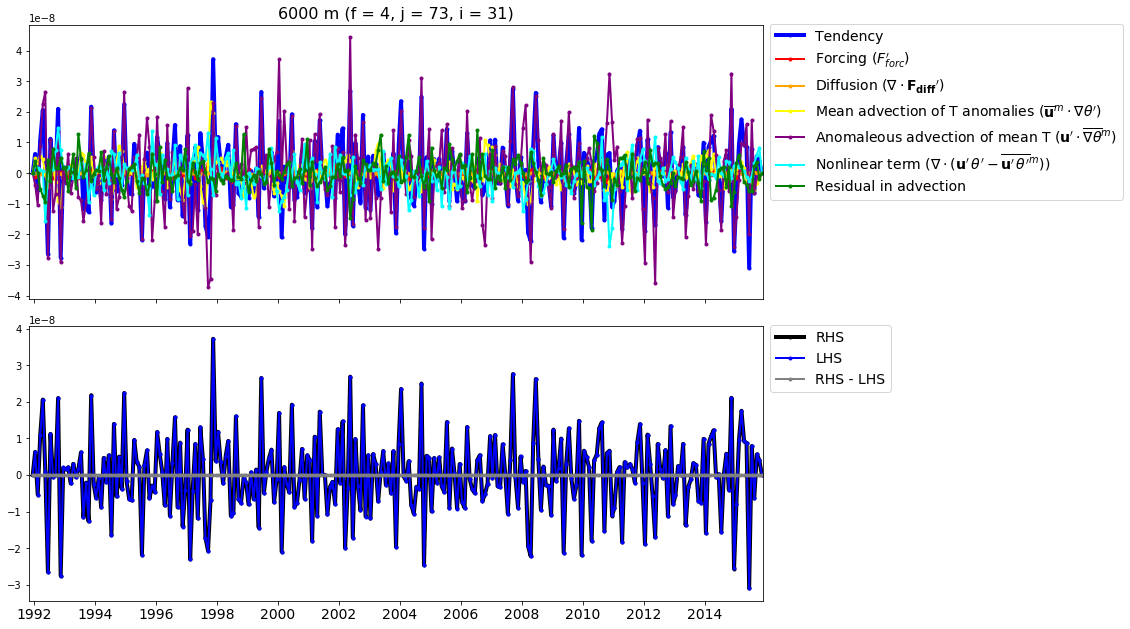

In [22]:
fig, axes = plt.subplots(2, 1,figsize=(17,10))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title('%s m (f = %s, j = %s, i = %s)' % (D,f,j,i), fontsize=16)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='blue', marker='.',label='Tendency')
plt.plot(results[1].time, results[1], lw=2, color='red', marker='.',
         label=r'Forcing ($F_{forc}^{\prime}$)')
plt.plot(results[2].time, results[2]+results[3], lw=2, color='orange', marker='.',
         label=r'Diffusion ($\nabla \cdot {\mathbf{F_{diff}}}^{\prime}$)')
plt.plot(results[3].time, results[4]+results[5], lw=2, color='yellow', marker='.',
         label=r'Mean advection of T anomalies ($\overline{\mathbf{u}}^m\cdot\nabla\theta^{\prime}$)')
plt.plot(results[4].time, results[6]+results[7], lw=2, color='purple', marker='.',
         label=r'Anomaleous advection of mean T ($\mathbf{u}^{\prime} \cdot \overline{\nabla\theta}^m$)')
plt.plot(results[5].time, results[8]+results[9], lw=2, color='cyan', marker='.',
         label=r'Nonlinear term ($\nabla \cdot ({\mathbf{u}}^{\prime}\,\theta^{\prime}-\overline{\mathbf{u}^{\prime}\,\theta^{\prime}}^m)$)')
plt.plot(results[6].time, results[10], lw=2, color='green', marker='.',label='Residual in advection')
#plt.xlim([ds_budgH_anom.time.values[0],ds_budgH_anom.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
#plt.yticks(np.arange(-4e-7,6e-7,2.0e-7),fontsize=14)
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(total.time, total, lw=4, color='k', marker='.',label='RHS')
plt.plot(results[0].time, results[0], lw=2, color='blue', marker='.',label='LHS')
plt.plot(results[0].time, total-results[0], lw=2, color='grey', marker='.',label='RHS - LHS')
#plt.xlim([ds_budgH_anom.time.values[0],ds_budgH_anom.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
#plt.yticks(np.arange(-4e-7,6e-7,2.0e-7),fontsize=14)

plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/tmp/figure.png')
plt.show()

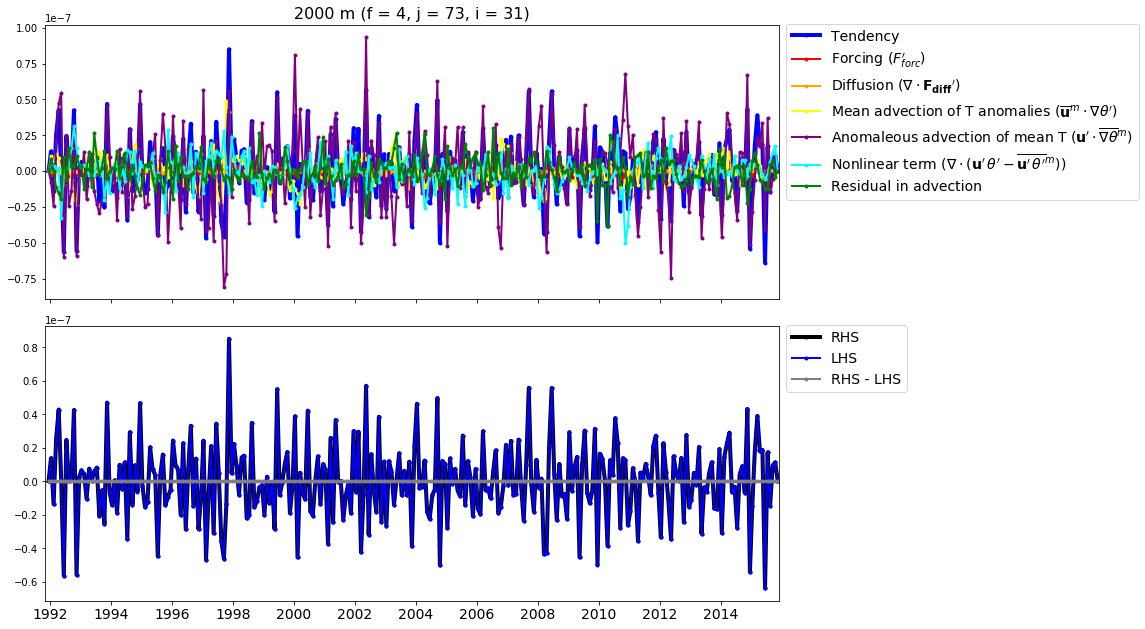

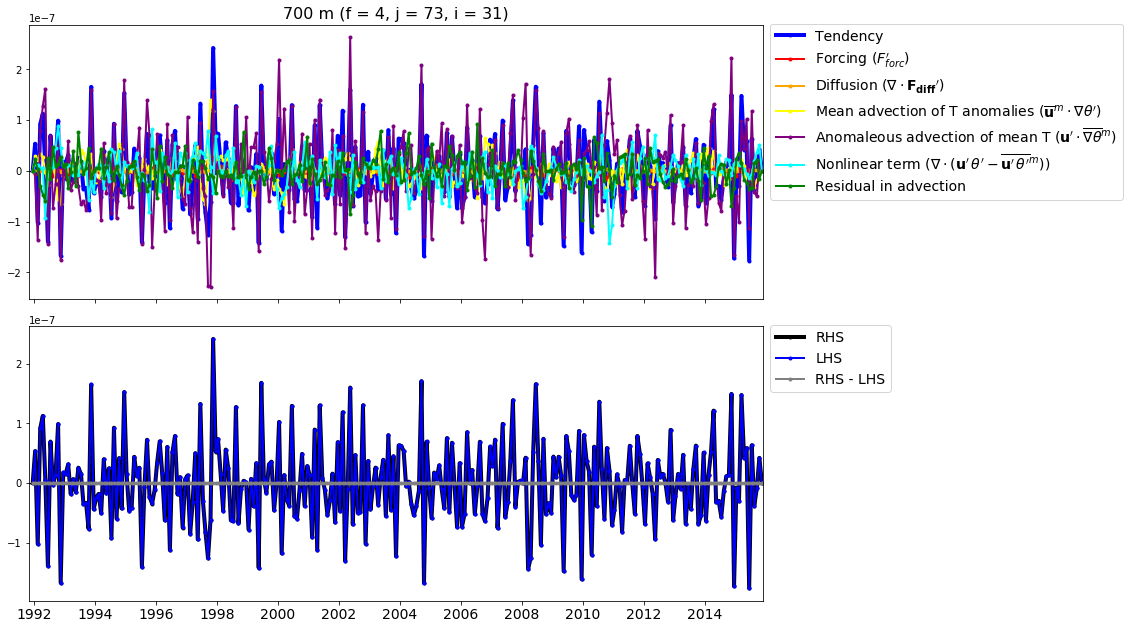

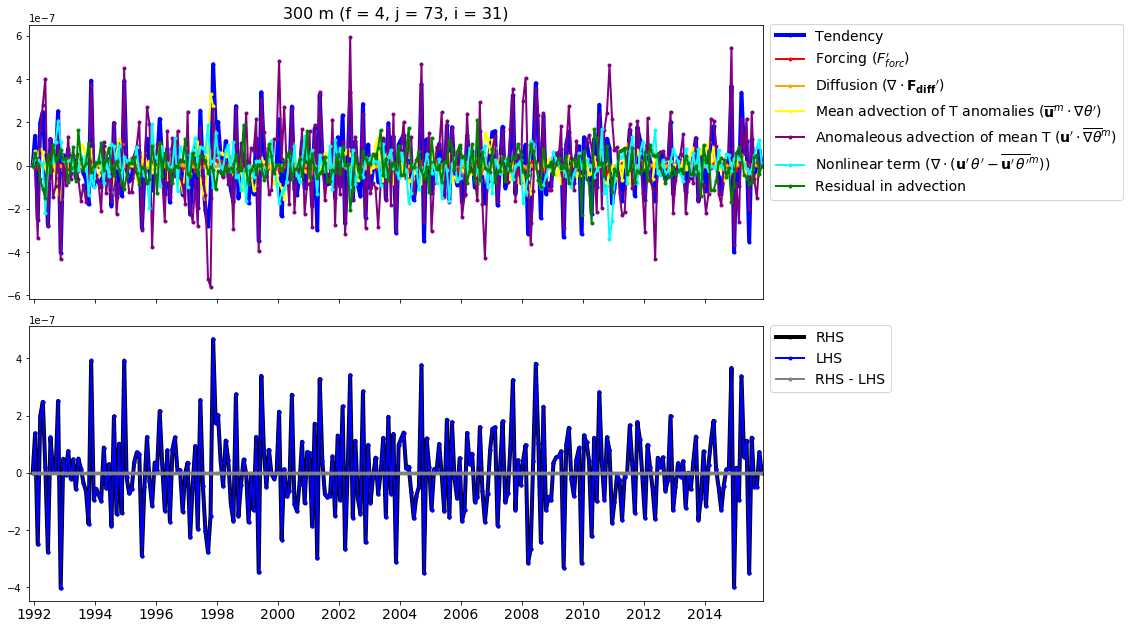